In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import seaborn as sns 
sns.set_theme()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error as mse 
import warnings
warnings.filterwarnings('ignore')

In [3]:
nyc = pd.read_csv('nyclistings.csv')

Data Exploration

In [4]:
nyc['neighbourhood_group'].value_counts()

Manhattan        17658
Brooklyn         16237
Queens            6916
Bronx             1691
Staten Island      429
Name: neighbourhood_group, dtype: int64

In [5]:
nyc.isnull().sum()

id                                    0
name                                 12
host_id                               0
host_name                             5
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10304
reviews_per_month                 10304
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           42930
dtype: int64

In [6]:
nyc.price.describe

<bound method NDFrame.describe of 0        150
1         60
2         75
3         68
4        275
        ... 
42926     76
42927     32
42928    127
42929    280
42930     78
Name: price, Length: 42931, dtype: int64>

Data Visualization <br> - Geospatial mapping of NYC visualizing the relations between boroughs and price <br> - Pie charts visualizing distributions between Room Types, Neighbourhood Groups, and Popular Neighbourhoods <br> - Heatmap demonstrating correlation between price and features <br> - Visual Distribution of Price

<Axes: xlabel='latitude', ylabel='longitude'>

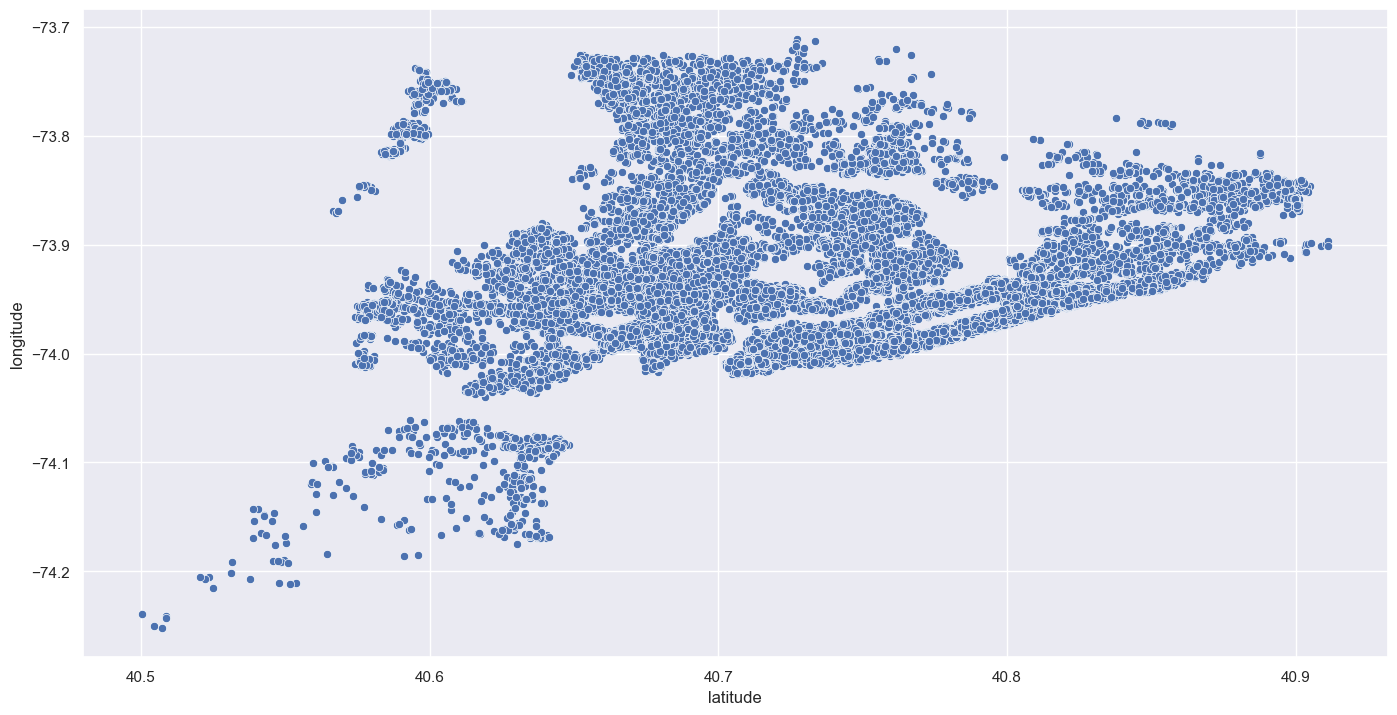

In [7]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=nyc, x='latitude', y='longitude')

In [8]:
# Dataframe for geospatial visualization
nyc_map = nyc[['latitude','longitude','price']]
nyc_map

latitude  longitude  price
0      40.753560 -73.985590    150
1      40.685350 -73.955120     60
2      40.803800 -73.967510     75
3      40.764570 -73.983170     68
4      40.662650 -73.994540    275
...          ...        ...    ...
42926  40.718976 -73.963985     76
42927  40.721703 -73.981473     32
42928  40.688700 -73.907650    127
42929  40.616911 -74.164652    280
42930  40.713091 -73.957205     78

[42931 rows x 3 columns]

In [9]:
# Geospatial data of new york city
map = gpd.read_file('/Users/alpha/Desktop/Projects/nycairbnb/Shapefiles and base map/geo_export_3e1c3d29-a810-4698-9c8c-0c853f1f9201.shp')

In [ ]:
# Coordinate reference system and longtitude/latitude coordinate system
crs = {'init':'epsg:4326'}

In [ ]:
# Generating points for using our coordinates
geometry = [Point(xy) for xy in zip(nyc_map['longitude'], nyc_map['latitude'])]
geometry[:4]

[<POINT (-73.986 40.754)>,
 <POINT (-73.955 40.685)>,
 <POINT (-73.968 40.804)>,
 <POINT (-73.983 40.765)>]

In [ ]:
# Generating new table with geopandas
geo_nyc = gpd.GeoDataFrame(nyc_map, crs=crs, geometry=geometry)
geo_nyc.head()

latitude  longitude  price                    geometry
0  40.75356  -73.98559    150  POINT (-73.98559 40.75356)
1  40.68535  -73.95512     60  POINT (-73.95512 40.68535)
2  40.80380  -73.96751     75  POINT (-73.96751 40.80380)
3  40.76457  -73.98317     68  POINT (-73.98317 40.76457)
4  40.66265  -73.99454    275  POINT (-73.99454 40.66265)

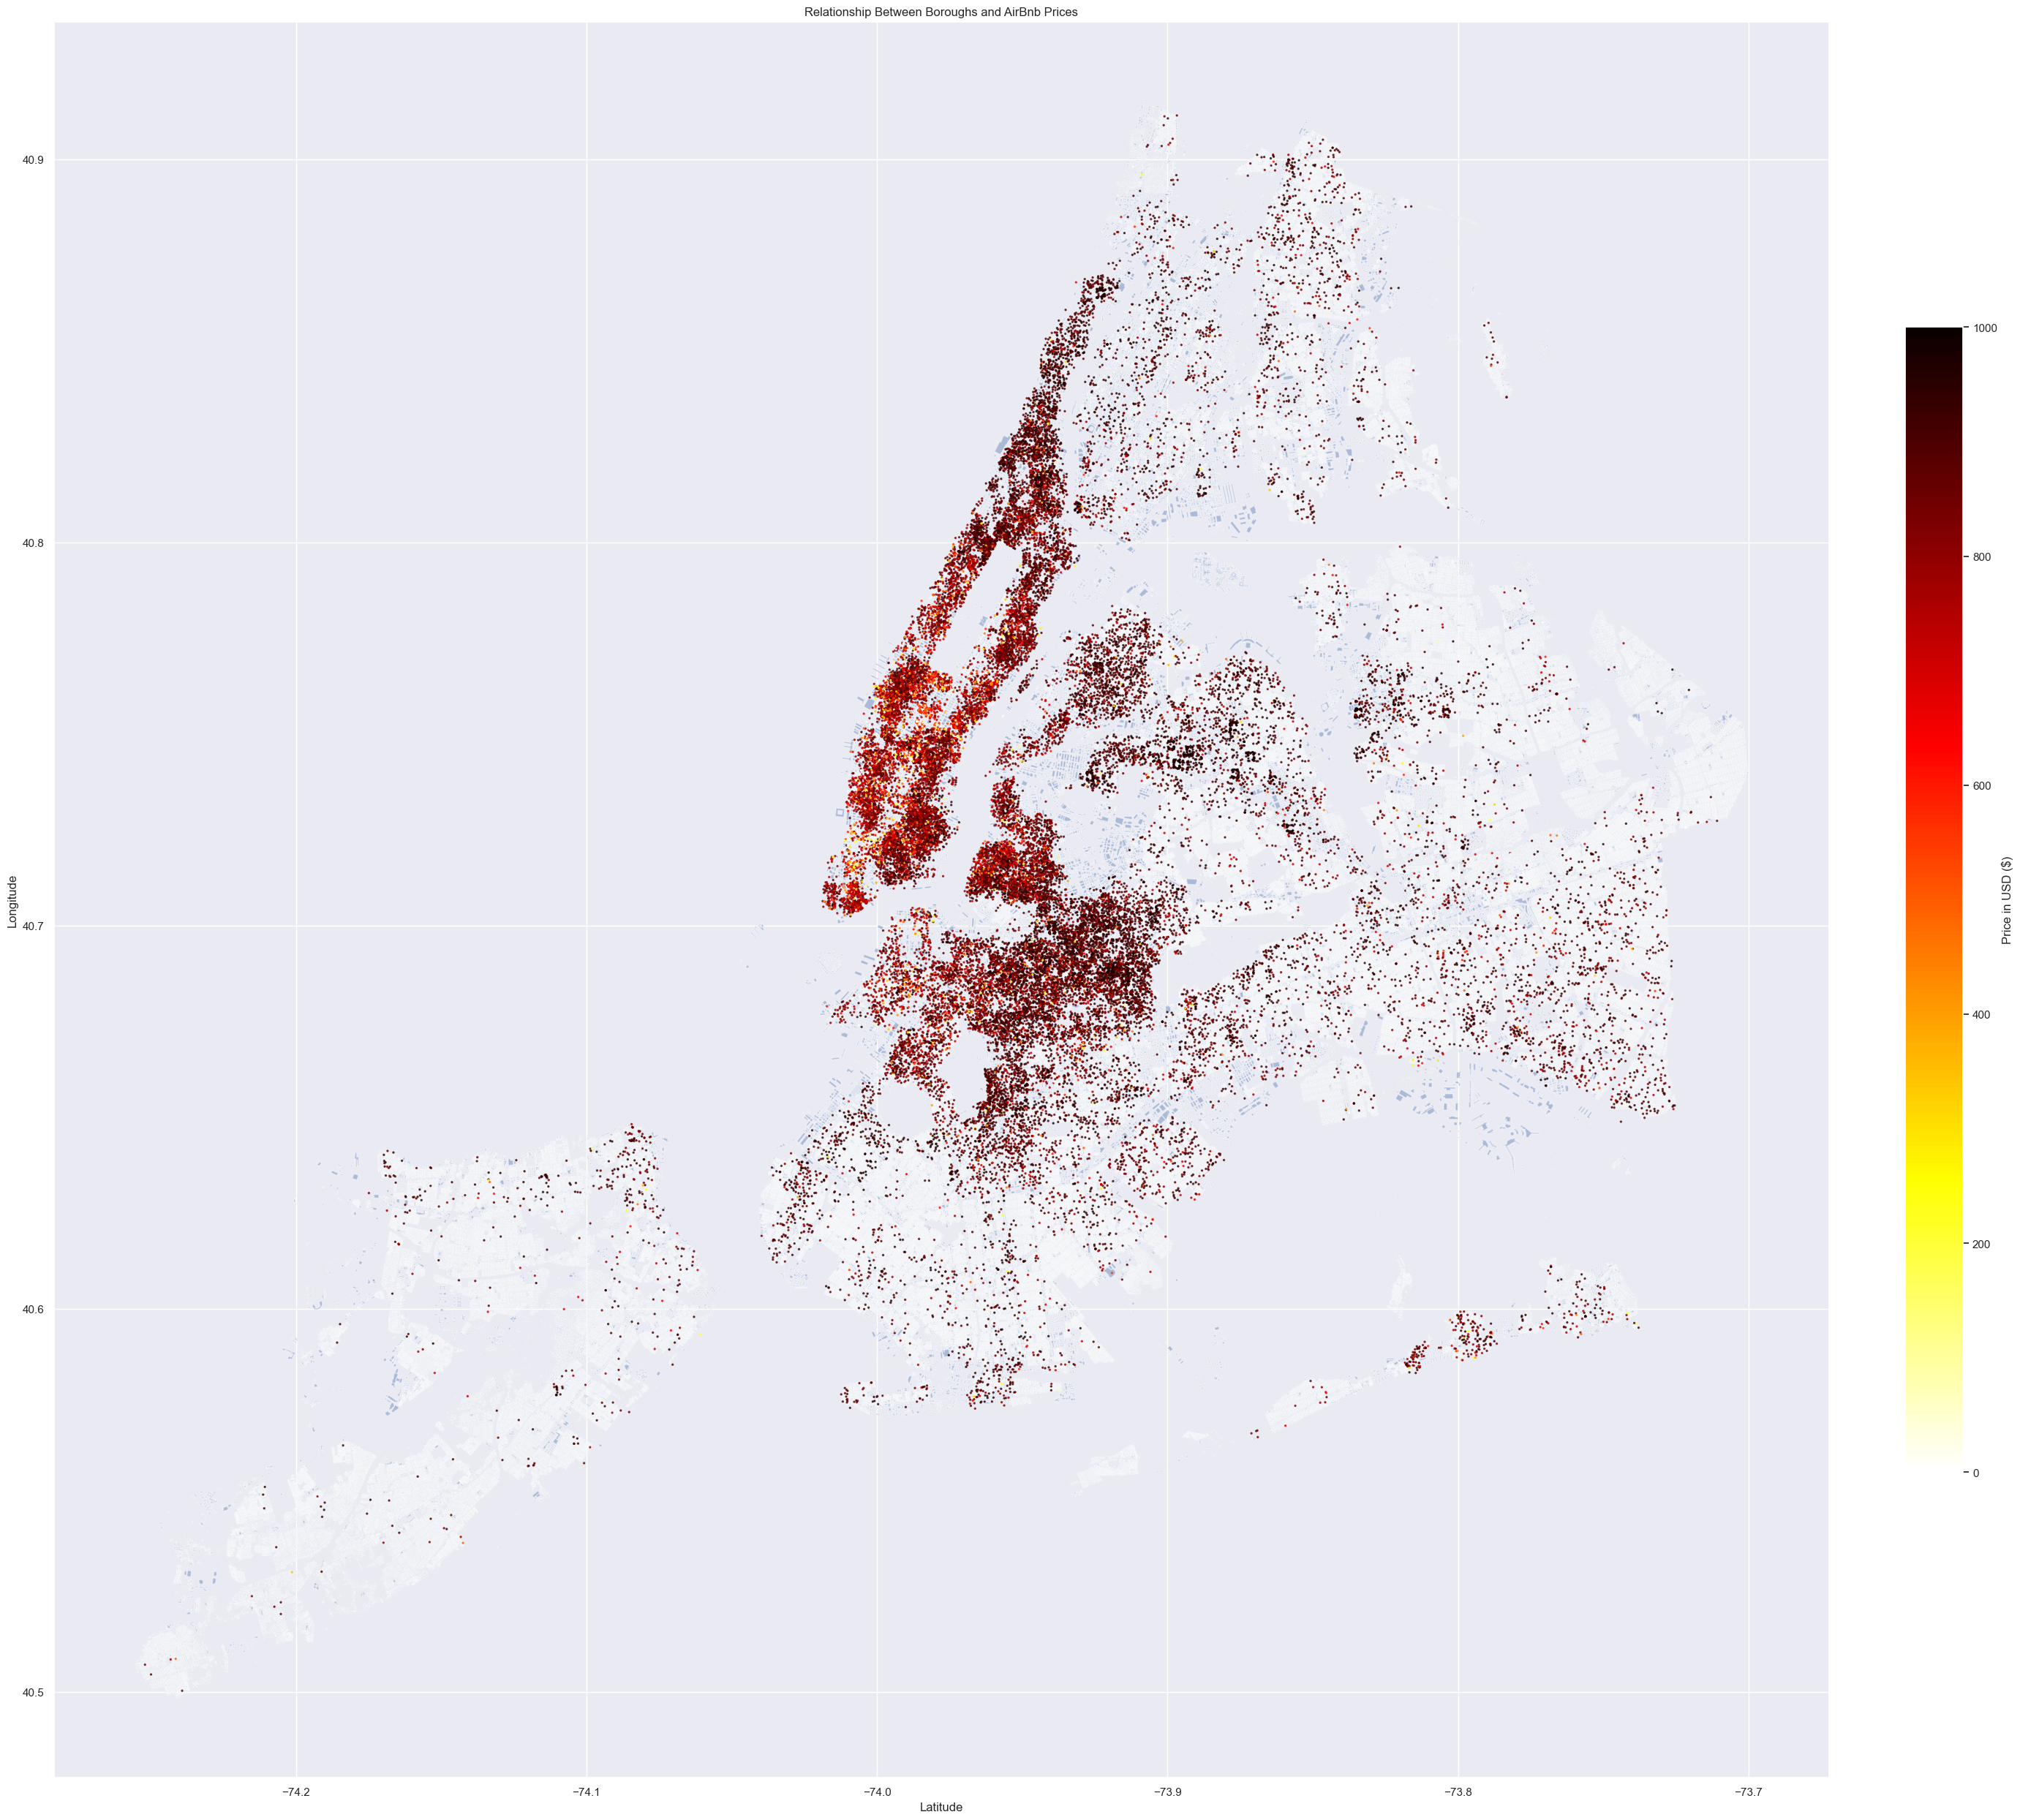

In [ ]:
fig,ax = plt.subplots(figsize= (30,30))
map.plot(ax=ax, alpha=.4)

geo_nyc.plot(column='price', ax=ax, markersize=2, alpha=.7, cmap='hot', vmin=0, vmax=1000)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Relationship Between Boroughs and AirBnb Prices')

# Setting a color gradient for each point between 0-1000 based on price
sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=0,vmax=1000))

# Creating color bar as legend 
cbar = plt.colorbar(sm ,fraction=0.03, pad=0.04)
cbar.set_label('Price in USD ($)')

<Axes: ylabel='room_type'>

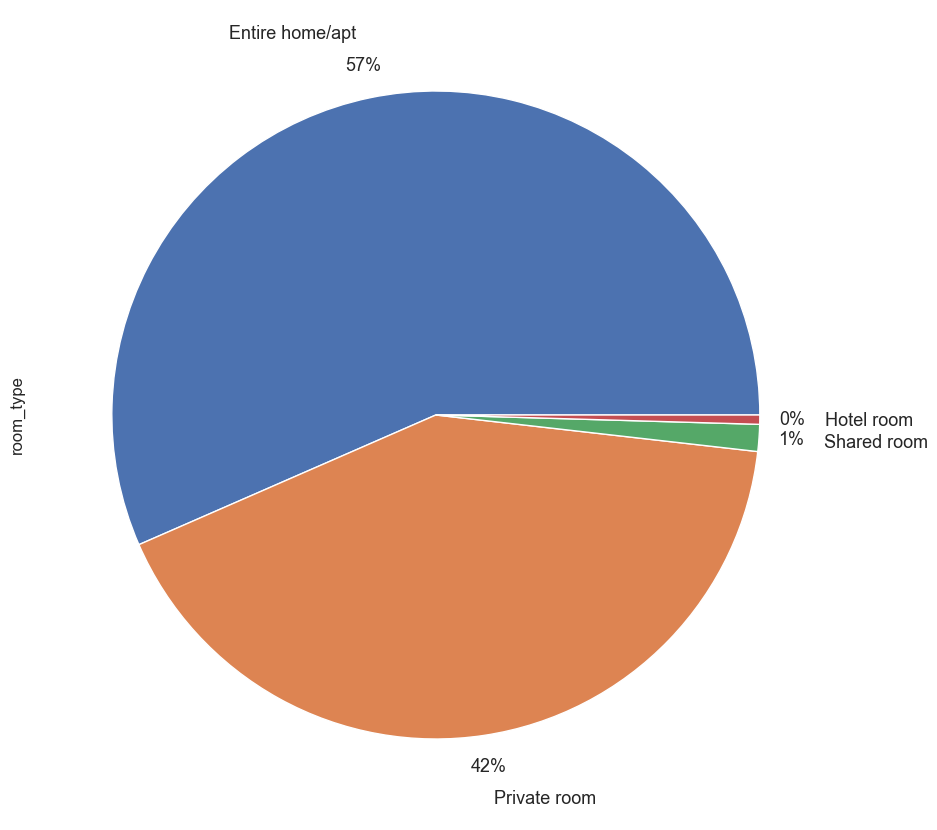

In [ ]:
fig = plt.figure(figsize=(10,10))
nyc['room_type'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13, pctdistance=1.1, labeldistance=1.2)

<Axes: ylabel='neighbourhood_group'>

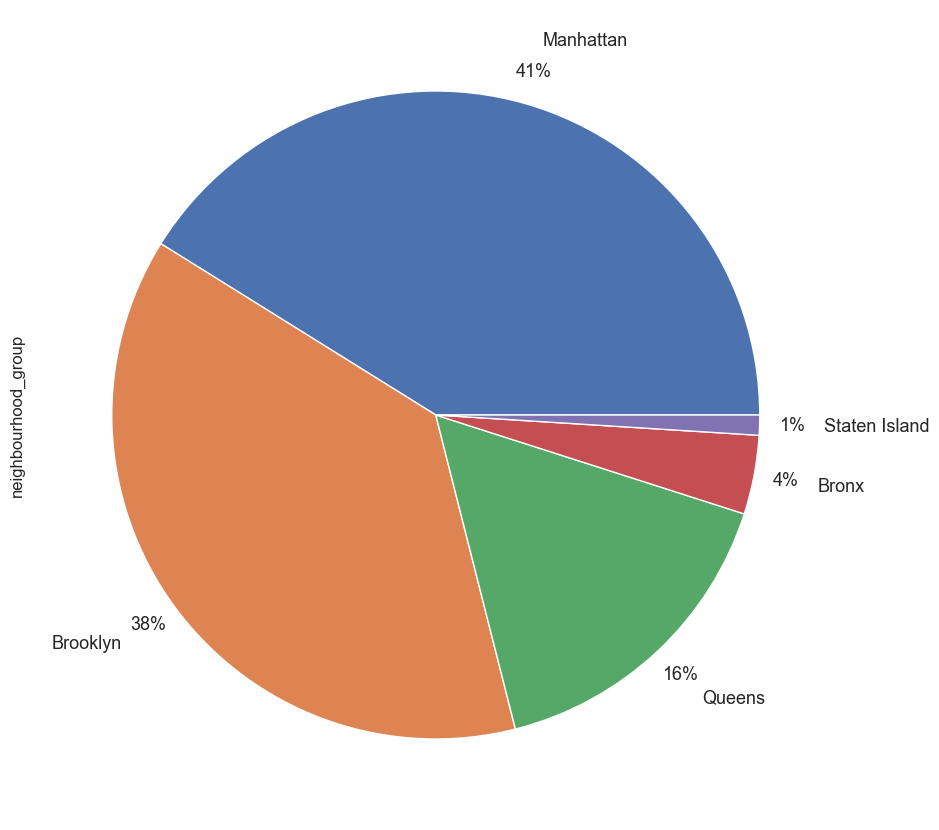

In [ ]:
fig = plt.figure(figsize=(10,10))
nyc['neighbourhood_group'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13, pctdistance=1.1, labeldistance=1.2)

<Axes: ylabel='neighbourhood'>

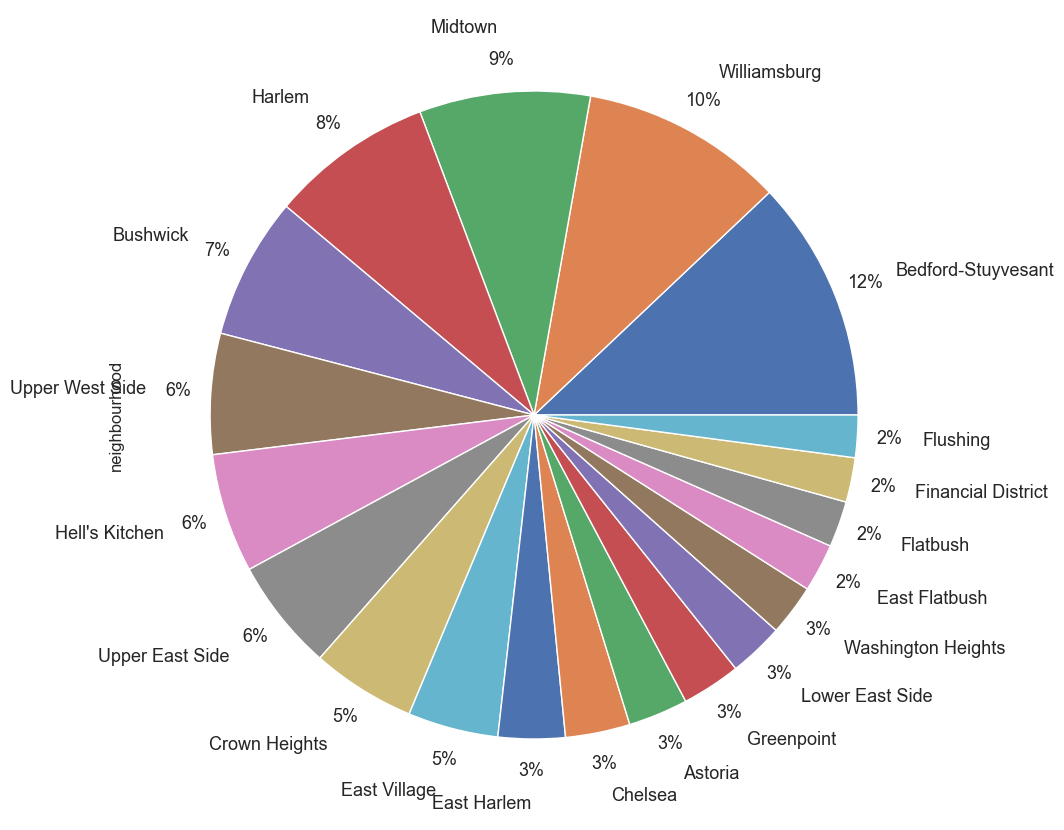

In [ ]:
fig = plt.figure(figsize=(10,10))
nyc['neighbourhood'].sort_values().value_counts().head(20).plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13, pctdistance=1.1, labeldistance=1.2)

<Axes: >

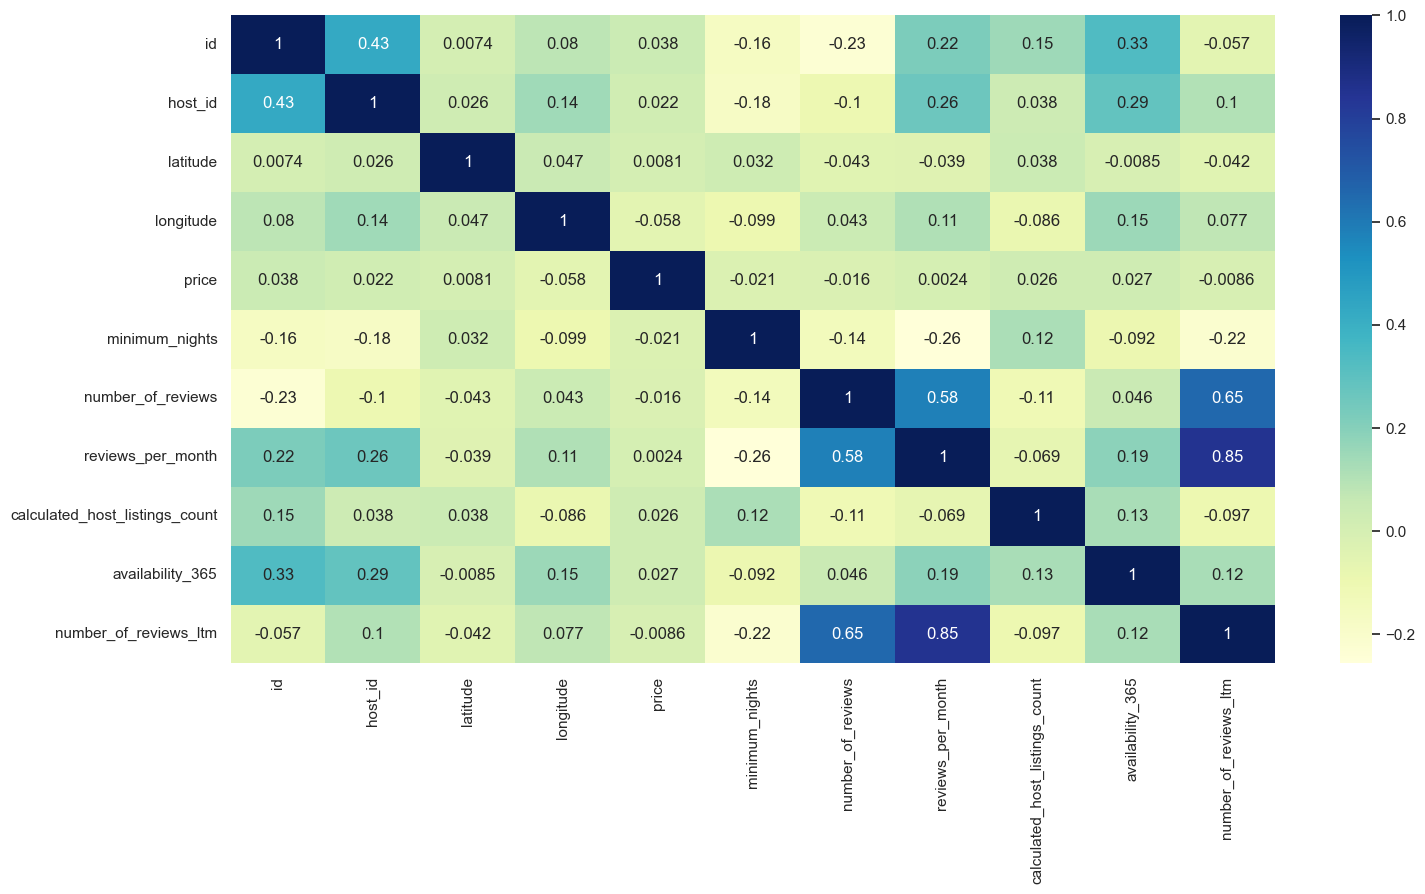

In [ ]:
#corr = nyc.corr()
plt.figure(figsize=(15,8))
sns.heatmap(nyc.corr(), annot=True, cmap='YlGnBu')

Text(0.5, 1.0, 'Price Distribution Plot')

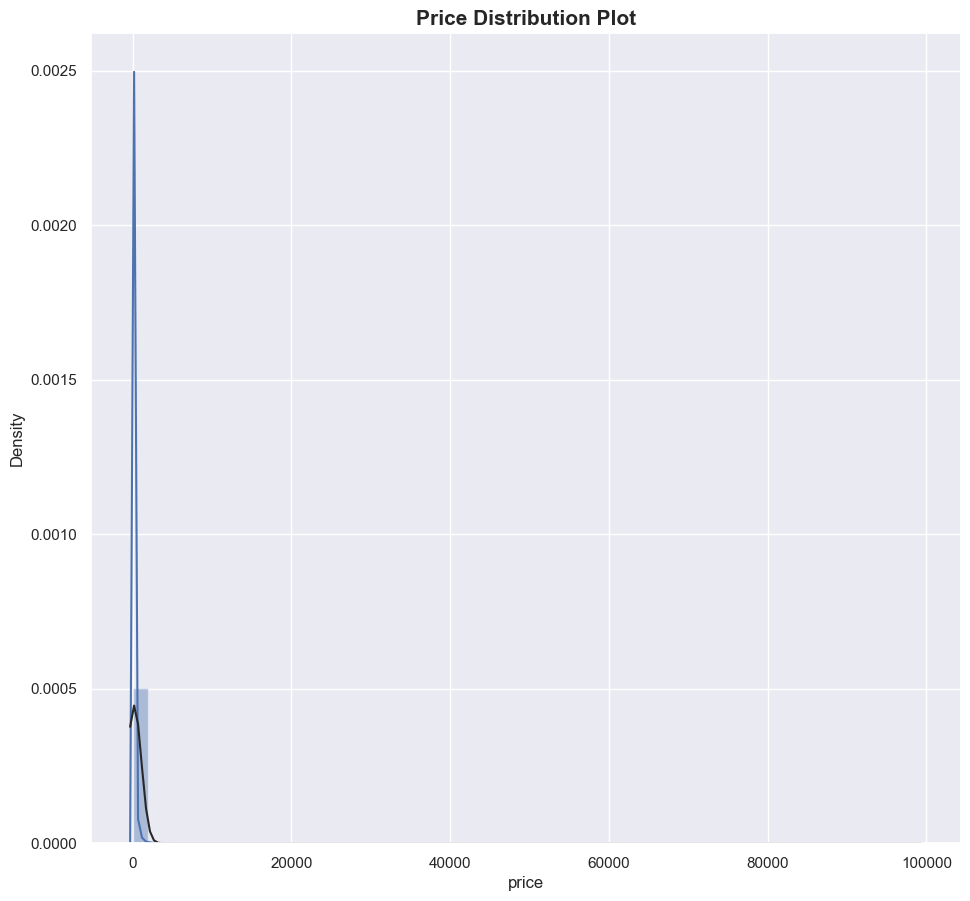

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(nyc['price'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

Normalizing Price with log transformation due to having a skewed distribution, easier to interpret data for statistical analysis. <br> Pricing now has a normal distribution

In [ ]:
nyc["price_log"] = np.log(nyc.price+1)
nyc = nyc.drop(columns=["price"])

Text(0.5, 1.0, 'Log-Price Distribution Plot')

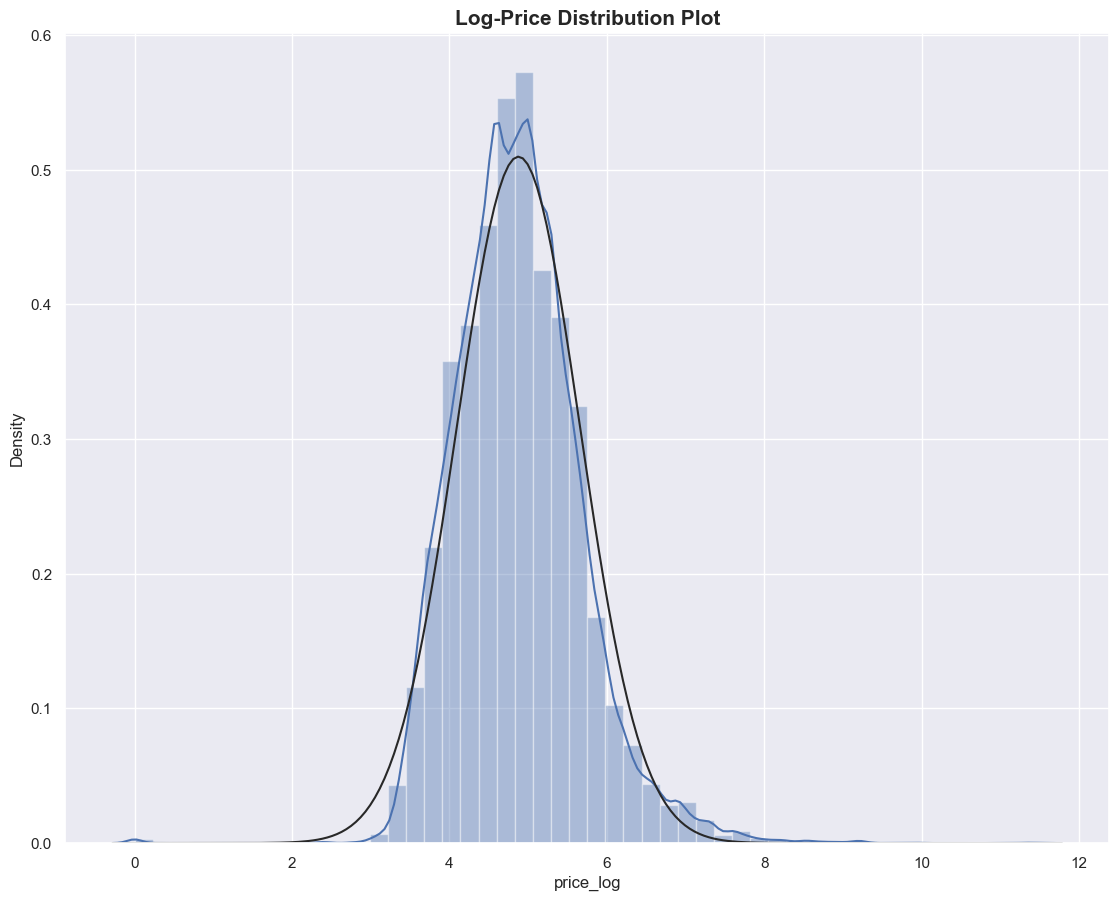

In [ ]:
plt.figure(figsize=(12,10))
sns.distplot(nyc['price_log'], fit=norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

Cleaning Dataset
- Filling in missing values for reviews per month with mean, which is ideal in this case
- Dropping unnecessary columns

In [ ]:
nyc["reviews_per_month"].fillna(nyc["reviews_per_month"].mean(), inplace=True)

In [ ]:
nyc = nyc.drop(columns=['id', 'host_id', 'name', 'host_name', 'last_review', 'number_of_reviews_ltm', 'license'], axis=1)

In [ ]:
nyc.shape

(42931, 11)

Proprocessing Data <br> - Transforming categorical features into numerical values  <br> - Standerizing the dataset for machine learning models

In [ ]:
le = LabelEncoder()
for col in nyc.columns:
    if nyc[col].dtype=='object':
        nyc[col]=le.fit_transform(nyc[col])

Partitioning Dataset into Train, Validation, and Test samples for machine learning ingestion
- Partition dataset
- Creating X variables for model prediction
- Creating Y variables for actual price

In [ ]:
train, test, val = nyc[:30000], nyc[30000:36465], nyc[36465:]
len(train),len(test),len(val)

(30000, 6465, 6466)

In [ ]:
X_train, y_train = train.drop(['price_log'], axis=1), train['price_log']
X_val, y_val = val.drop(['price_log'], axis=1), val['price_log']
X_test, y_test = test.drop(['price_log'], axis=1), test['price_log']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((30000, 10), (30000,), (6466, 10), (6466,), (6465, 10), (6465,))

Scaling prediction samples for model

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

Model Building
- Used LinearRegression, KNeighborsRegressor, RandomForestRegressor, GradientBoostingRegressor 
- Implemented Mean Square Error to show how accurately model predicts price
- Added parameters to models, but could add more to fine tune them
- Visualizing best model with Scatterplots

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
mse(lr.predict(X_train), y_train, squared=False), mse(lr.predict(X_val), y_val, squared=False)

(0.6014799187968233, 0.7622046638698243)

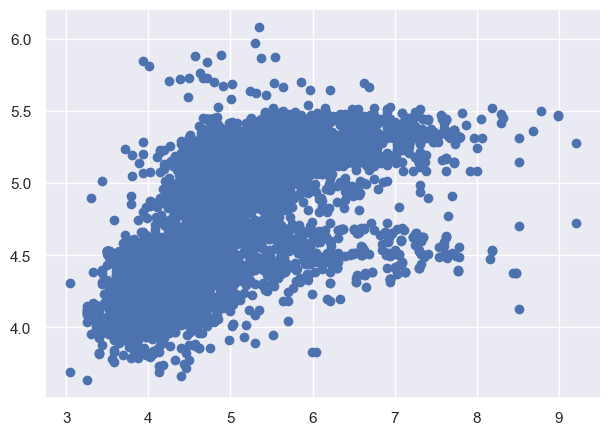

In [ ]:
plt.scatter(y_val, lr.predict(X_val))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=100).fit(X_train, y_train)
mse(knn.predict(X_train), y_train, squared=False), mse(knn.predict(X_val), y_val, squared=False), mse(knn.predict(X_test), y_test, squared=False)

(0.535853640952457, 0.7041958842135251, 0.5648253989017941)

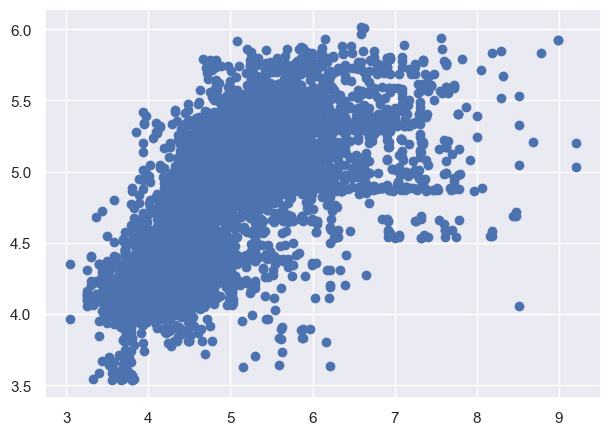

In [ ]:
plt.scatter(y_val, knn.predict(X_val))

In [ ]:
from sklearn.ensemble import RandomForestRegressor 

rfr = RandomForestRegressor(max_depth=5).fit(X_train, y_train)
mse(rfr.predict(X_train), y_train, squared=False), mse(rfr.predict(X_val), y_val, squared=False)

(0.5390206048564419, 0.7043160044415879)

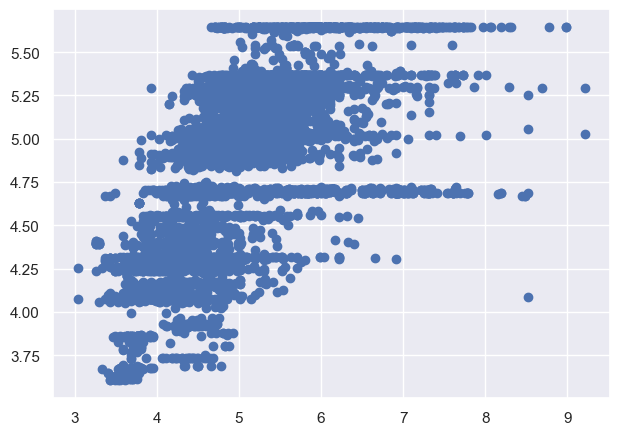

In [ ]:
plt.scatter(y_val, rfr.predict(X_val))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
mse(gbr.predict(X_train), y_train, squared=False), mse(gbr.predict(X_val), y_val, squared=False), mse(gbr.predict(X_test), y_test, squared=False)

(0.5133032744505325, 0.6778799879041415, 0.5598279660754898)

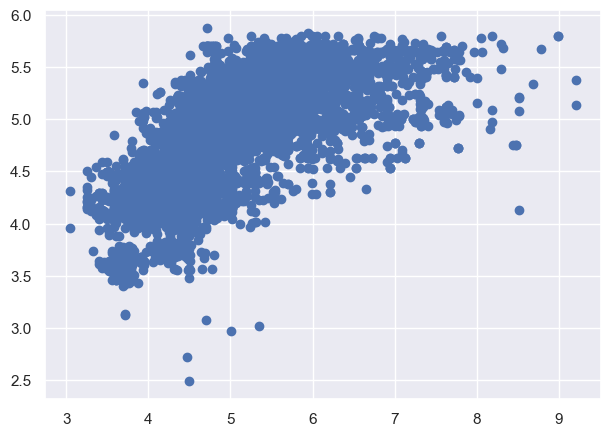

In [ ]:
plt.scatter(y_val, gbr.predict(X_val))

GradientBoostingRegressor seemed to be the model with the least amount of Overfitting

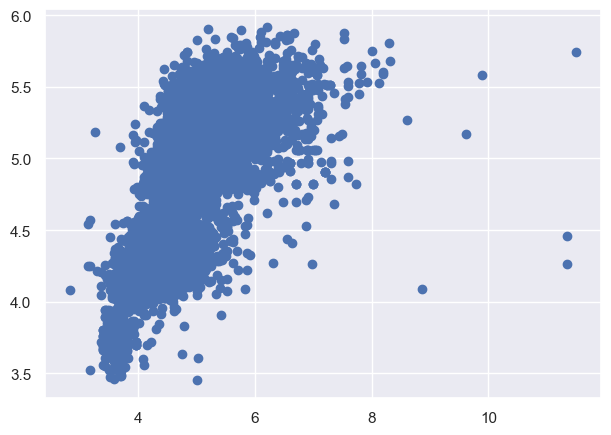

In [ ]:
plt.scatter(y_test, gbr.predict(X_test))